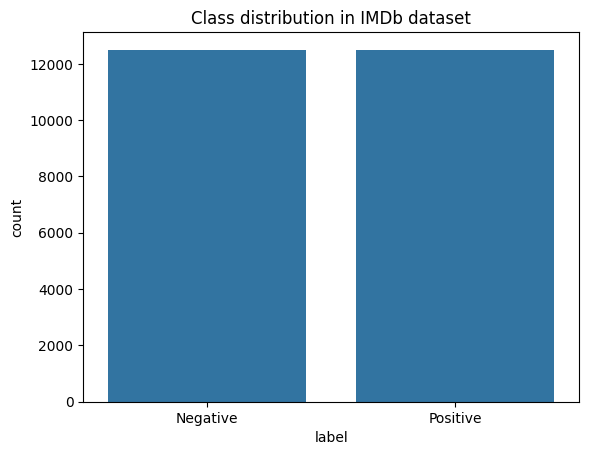

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3


In [ ]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import AdamW
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datasets import load_dataset

# Шаг 1: Загрузка и подготовка данных
# Используем IMDb dataset из HuggingFace Datasets
dataset = load_dataset("imdb")

# Преобразуем датасет в pandas DataFrame для удобства работы
df = pd.DataFrame(dataset['train'])
df['label'] = df['label'].map({0: 'Negative', 1: 'Positive'})

# Визуализация распределения классов
sns.countplot(data=df, x='label')
plt.title('Class distribution in IMDb dataset')
plt.show()

# Возьмем для примера только 5000 записей, чтобы ускорить процесс
df = df.sample(5000, random_state=42)
texts = df['text'].tolist()
labels = df['label'].map({'Negative': 0, 'Positive': 1}).tolist()

# Разделение данных на тренировочную и тестовую выборки
train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)

# Шаг 2: Токенизация данных с помощью BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Создание специального Dataset для использования в DataLoader
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

# Параметры модели
MAX_LEN = 128
BATCH_SIZE = 16
EPOCHS = 3

# Создание DataLoader для тренировочных и тестовых данных
train_dataset = SentimentDataset(train_texts, train_labels, tokenizer, MAX_LEN)
val_dataset = SentimentDataset(val_texts, val_labels, tokenizer, MAX_LEN)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

# Шаг 3: Загрузка модели BERT
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Шаг 4: Оптимизатор и функция потерь
optimizer = AdamW(model.parameters(), lr=2e-5)

# Шаг 5: Обучение модели
def train_epoch(model, data_loader, optimizer, device):
    model = model.train()
    total_loss = 0
    correct_predictions = 0

    for batch in data_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        _, preds = torch.max(logits, dim=1)
        correct_predictions += torch.sum(preds == labels)
        total_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return correct_predictions.double() / len(data_loader.dataset), total_loss / len(data_loader)

def eval_model(model, data_loader, device):
    model = model.eval()
    correct_predictions = 0
    val_loss = 0

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            _, preds = torch.max(logits, dim=1)
            correct_predictions += torch.sum(preds == labels)
            val_loss += loss.item()

    return correct_predictions.double() / len(data_loader.dataset), val_loss / len(data_loader)

# Основной цикл обучения
for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    train_acc, train_loss = train_epoch(model, train_loader, optimizer, device)
    print(f'Train loss {train_loss}, accuracy {train_acc}')

    val_acc, val_loss = eval_model(model, val_loader, device)
    print(f'Val loss {val_loss}, accuracy {val_acc}')

# Шаг 6: Оценка на тестовых данных
y_pred = []
y_true = []

model.eval()
with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs.logits, dim=1)

        y_pred.extend(preds.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

# Оценка точности модели
print('Classification Report:')
print(classification_report(y_true, y_pred, target_names=['Negative', 'Positive']))

# Визуализация результатов
sns.heatmap(pd.crosstab(pd.Series(y_true, name='Actual'), pd.Series(y_pred, name='Predicted')), annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix')
plt.show()
